In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import math

In [3]:
df=pd.read_excel("Dataset TD5.xlsx",header=2)

In [5]:
# Groupe 1 : GBPEUR (Colonnes 0, 1, 2)
df_gbp = df.iloc[:, 0:3].copy()
df_gbp.columns = ['Date', 'HIGH', 'LOW'] # Renommage pour être sûr
df_gbp['Currency'] = 'GBPEUR' # Optionnel : ajouter une étiquette

# Groupe 2 : SEKEUR (Colonnes 4, 5, 6) -> On saute la colonne 3 qui est vide
df_sek = df.iloc[:, 4:7].copy()
df_sek.columns = ['Date', 'HIGH', 'LOW']
df_sek['Currency'] = 'SEKEUR'

# Groupe 3 : CADEUR (Colonnes 8, 9, 10) -> On saute la colonne 7 qui est vide
df_cad = df.iloc[:, 8:11].copy()
df_cad.columns = ['Date', 'HIGH', 'LOW']
df_cad['Currency'] = 'CADEUR'

# 3. Vérification des résultats
print("Aperçu GBPEUR :")
print(df_gbp.head())
print("\nAperçu SEKEUR :")
print(df_sek.head())

Aperçu GBPEUR :
                     Date    HIGH     LOW Currency
0 2016-03-07 08:59:59.990  1.2932  1.2917   GBPEUR
1 2016-03-07 09:15:00.000  1.2940  1.2930   GBPEUR
2 2016-03-07 09:30:00.000  1.2943  1.2922   GBPEUR
3 2016-03-07 09:45:00.000  1.2930  1.2913   GBPEUR
4 2016-03-07 10:00:00.000  1.2931  1.2921   GBPEUR

Aperçu SEKEUR :
                     Date     HIGH      LOW Currency
0 2016-03-07 08:59:59.990  0.10725  0.10720   SEKEUR
1 2016-03-07 09:15:00.000  0.10728  0.10717   SEKEUR
2 2016-03-07 09:30:00.000  0.10726  0.10719   SEKEUR
3 2016-03-07 09:45:00.000  0.10728  0.10721   SEKEUR
4 2016-03-07 10:00:00.000  0.10725  0.10719   SEKEUR


In [69]:
df_gbp["Date"] = pd.to_datetime(df_gbp["Date"])
df_sek["Date"] = pd.to_datetime(df_sek["Date"])
df_cad["Date"] = pd.to_datetime(df_cad["Date"])

df_gbp.set_index("Date", inplace=True)
df_sek.set_index("Date", inplace=True)
df_cad.set_index("Date", inplace=True)

In [7]:
for d in [df_gbp, df_sek, df_cad]:
    d['t'] = range(len(d))
    d['k']= d['t'] - 1
    d['z(t)'] = (d['HIGH'] + d['LOW']) / 2
    d['returns'] = np.log(d['z(t)'] / d['z(t)'].shift(1))
    valeurs_returns = d['returns'].fillna(0).values

In [39]:
df_gbp.head()

,Date,HIGH,LOW,Currency,z(t),returns,t,k
0,2016-03-07 08:59:59.990,1.2932,1.2917,GBPEUR,1.29245,NaN,0,-1
1,2016-03-07 09:15:00.000,1.2940,1.2930,GBPEUR,1.29350,0.000812,1,0
2,2016-03-07 09:30:00.000,1.2943,1.2922,GBPEUR,1.29325,-0.000193,2,1
3,2016-03-07 09:45:00.000,1.2930,1.2913,GBPEUR,1.29215,-0.000851,3,2
4,2016-03-07 10:00:00.000,1.2931,1.2921,GBPEUR,1.29260,0.000348,4,3


In [77]:
def correlation(x,y):
    n=len(x)
    if n != len(y) or n == 0:
        return 0
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    numerator = 0
    sum_sq_diff_x = 0
    sum_sq_diff_y = 0
    for xi, yi in zip(x, y):
        diff_x = xi - mean_x
        diff_y = yi - mean_y
        numerator += diff_x * diff_y
        sum_sq_diff_x += diff_x ** 2
        sum_sq_diff_y += diff_y ** 2
    denominator = math.sqrt(sum_sq_diff_x * sum_sq_diff_y)
    if denominator == 0:
        return 0
    return numerator / denominator

In [101]:
axe_j = range(-7, 19) 

corr_gbp_sek_list = []
corr_gbp_cad_list = []
corr_sek_cad_list = []

for j in axe_j:
    
    coeffs_stock = {}
    window_size = 2**(-j)
    nb_coeffs = 0
    
    for name, d in [('GBPEUR', df_gbp), ('SEKEUR', df_sek), ('CADEUR', df_cad)]:
        
        results = []
        avg_val = d["returns"].fillna(0).values 
        t_val = d["t"].values
        k_list = d["k"].values 
        
        for k in k_list:
            borne_inf = k * 2**(-j)
            borne_sup = (k + 1) * 2**(-j)
            
            masque = (t_val >= borne_inf) & (t_val < borne_sup)
            
            somme_locale = np.sum(avg_val[masque])
            coef = (2**(j/2)) * somme_locale
            results.append(coef)
        
        coeffs_stock[name] = results
        nb_coeffs = int(len(d) / window_size) # we delete the values after the window size because they will all be 0
    v_gbp = coeffs_stock['GBPEUR']
    v_sek = coeffs_stock['SEKEUR']
    v_cad = coeffs_stock['CADEUR']
    
    n = nb_coeffs_utiles
    
    if n > 1:
        c_gs = correlation(v_gbp[:n], v_sek[:n])
        c_gc = correlation(v_gbp[:n], v_cad[:n])
        c_sc = correlation(v_sek[:n], v_cad[:n])
    else:
        c_gs, c_gc, c_sc = np.nan, np.nan, np.nan # not enough data to calculate coefficients
        
    # Stockage
    corr_gbp_sek_list.append(c_gs)
    corr_gbp_cad_list.append(c_gc)
    corr_sek_cad_list.append(c_sc)

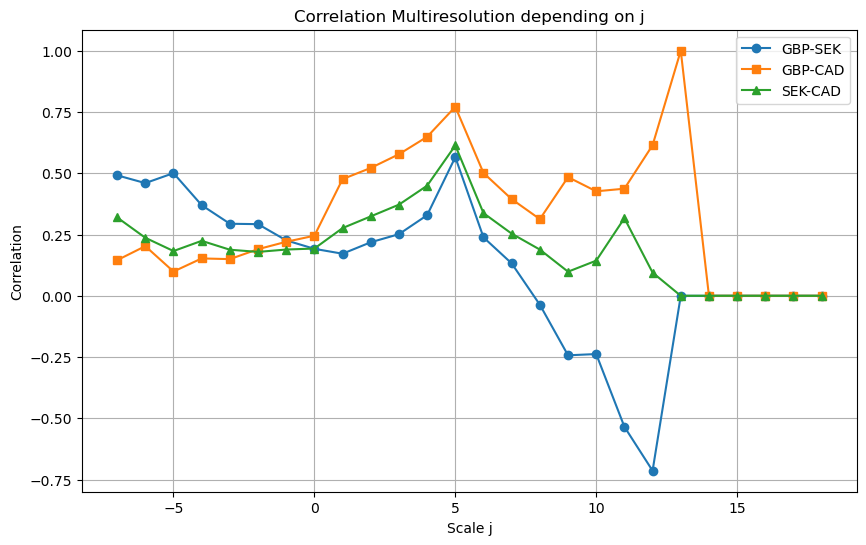

In [103]:
plt.figure(figsize=(10, 6))

plt.plot(axe_j, corr_gbp_sek_list, marker='o', label='GBP-SEK')
plt.plot(axe_j, corr_gbp_cad_list, marker='s', label='GBP-CAD')
plt.plot(axe_j, corr_sek_cad_list, marker='^', label='SEK-CAD')

plt.title("Correlation Multiresolution depending on j")
plt.xlabel("Scale j")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)

plt.show()

## Question 3

In [9]:
for df in [df_gbp, df_sek, df_cad]:
    df['X'] = np.log(df['z(t)'])

df_gbp.head()

,Date,HIGH,LOW,Currency,t,k,z(t),returns,X
0,2016-03-07 08:59:59.990,1.2932,1.2917,GBPEUR,0,-1,1.29245,NaN,0.256540
1,2016-03-07 09:15:00.000,1.2940,1.2930,GBPEUR,1,0,1.29350,0.000812,0.257352
2,2016-03-07 09:30:00.000,1.2943,1.2922,GBPEUR,2,1,1.29325,-0.000193,0.257158
3,2016-03-07 09:45:00.000,1.2930,1.2913,GBPEUR,3,2,1.29215,-0.000851,0.256307
4,2016-03-07 10:00:00.000,1.2931,1.2921,GBPEUR,4,3,1.29260,0.000348,0.256656


In [38]:
M2=0
n=len(df_gbp)
j=0
for i in range (1, n):
    M2=M2+np.abs(df_gbp["X"].iloc[i] - df_gbp["X"].iloc[i-1])**2
M2=M2*(1/n)

In [40]:
M2

3.8899736801539624e-07

In [42]:
M2_prime=0
n=len(df_gbp)
for i in range (2, n, 2):
    M2_prime = M2_prime + np.abs(df_gbp["X"].iloc[i] - df_gbp["X"].iloc[i-2])**2
M2_prime=M2_prime*(2/n)

In [44]:
M2_prime

9.875192246954796e-07

In [46]:
H_gbp=(1/2)*math.log2(M2_prime/M2)

In [48]:
H_gbp

0.6720242202463704

In [50]:
M2=0
n=len(df_sek)
j=0
for i in range (1, n):
    M2=M2+np.abs(df_sek["X"].iloc[i] - df_sek["X"].iloc[i-1])**2
M2=M2*(1/n)

In [52]:
M2_prime=0
n=len(df_sek)
for i in range (2, n, 2):
    M2_prime = M2_prime + np.abs(df_sek["X"].iloc[i] - df_sek["X"].iloc[i-2])**2
M2_prime=M2_prime*(2/n)

In [54]:
H_sek=(1/2)*math.log2(M2_prime/M2)

In [56]:
H_sek

0.6538170311483457

In [58]:
M2=0
n=len(df_cad)
j=0
for i in range (1, n):
    M2=M2+np.abs(df_cad["X"].iloc[i] - df_cad["X"].iloc[i-1])**2
M2=M2*(1/n)

In [60]:
M2_prime=0
n=len(df_cad)
for i in range (2, n, 2):
    M2_prime = M2_prime + np.abs(df_cad["X"].iloc[i] - df_cad["X"].iloc[i-2])**2
M2_prime=M2_prime*(2/n)

In [62]:
H_cad=(1/2)*math.log2(M2_prime/M2)

In [64]:
H_cad

0.6549201498228575

In [83]:
daily_prices_gbp = df_gbp["X"].resample('D').last().dropna()
daily_log_returns_gbp = np.log(daily_prices_gbp / daily_prices_gbp.shift(1)).dropna()
daily_vol_gbp = daily_log_returns_gbp.std()
annual_vol_hurst_gbp = daily_vol_gbp * (252 ** H_gbp)
annual_vol_std_gbp = daily_vol_gbp * np.sqrt(252)

In [85]:
annual_vol_hurst_gbp

1.4807705589786666

In [87]:
annual_vol_std_gbp

0.5719903679786457

In [89]:
daily_prices_sek = df_sek["X"].resample('D').last().dropna()
daily_log_returns_sek = np.log(daily_prices_sek / daily_prices_sek.shift(1)).dropna()
daily_vol_sek = daily_log_returns_sek.std()
annual_vol_hurst_sek = daily_vol_sek * (252 ** H_sek)
annual_vol_std_sek = daily_vol_sek * np.sqrt(252)

In [91]:
annual_vol_hurst_sek

0.050083122931325844

In [93]:
annual_vol_std_sek

0.02139513837570949

In [95]:
daily_prices_cad = df_cad["X"].resample('D').last().dropna()
daily_log_returns_cad = np.log(daily_prices_cad / daily_prices_cad.shift(1)).dropna()
daily_vol_cad = daily_log_returns_cad.std()
annual_vol_hurst_cad = daily_vol_cad * (252 ** H_cad)
annual_vol_std_cad = daily_vol_cad * np.sqrt(252)

In [97]:
annual_vol_hurst_cad

0.5099232296337406

In [99]:
annual_vol_std_cad

0.2165107503888522